In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm

In [2]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())

# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 12
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

In [3]:
import os
# Set enviornment variable TORCH_HOME to specify where to download pretrained models
os.environ['TORCH_HOME'] = os.path.expanduser('~/TORCH_HOME')

In [4]:
# PCA to reduce dimensionality to 2 and plot
from sklearn.decomposition import PCA

In [5]:
import torchvision.transforms as transforms
import torch

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
# Download CIFAIR10 dataset in ~/TORCH_HOME/datasets/CIFAR10
from torchvision.datasets import CIFAR10

ds_cifar = CIFAR10(root=os.path.expanduser('~/TORCH_HOME/datasets'), 
                   transform=transform,
                   download=True)

Files already downloaded and verified


In [7]:
ds_cifar

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/nipun.batra/TORCH_HOME/datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [44]:
# Split dataset into train, pool and test
# train: 10 images per class
# test: 100 images per class
# pool: remaining images

from torch.utils.data import Subset
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Get indices of all images in the dataset
indices = np.arange(len(ds_cifar))

# Shuffle indices
np.random.shuffle(indices)

# Split indices into train, pool and test

# 50 images per class in train
train_indices = []
for i in range(10):
    train_indices.extend(indices[np.array(ds_cifar.targets) == i][:50])

# 100 images per class in test
test_indices = []
for i in range(10):
    test_indices.extend(indices[np.array(ds_cifar.targets) == i][50:150])

# Remaining images in pool
pool_indices = np.setdiff1d(indices, np.concatenate([train_indices, test_indices]))


In [45]:
indices.shape

(50000,)

In [46]:
indices[np.array(ds_cifar.targets) == 0][:10]

array([33109, 36480, 21123, 17523,  2530, 27578, 46915,  9801,  9405,
        7905])

In [47]:
# Print number of images in each set
print(f'Number of images in train: {len(train_indices)}')
print(f'Number of images in test: {len(test_indices)}')
print(f'Number of images in pool: {len(pool_indices)}')

Number of images in train: 500
Number of images in test: 1000
Number of images in pool: 48500


In [48]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [49]:
# image size
ds_cifar[0][0].shape

torch.Size([3, 32, 32])

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [51]:
# Create PyTorch dataloaders for train, pool and test
train_indices = torch.tensor(train_indices).to(device)

from torch.utils.data import DataLoader

train_loader = DataLoader(Subset(ds_cifar, train_indices), batch_size=32, shuffle=True, pin_memory=True)
pool_loader = DataLoader(Subset(ds_cifar, pool_indices), batch_size=32, shuffle=True)
test_loader = DataLoader(Subset(ds_cifar, test_indices), batch_size=32, shuffle=True)

In [52]:
train_loader

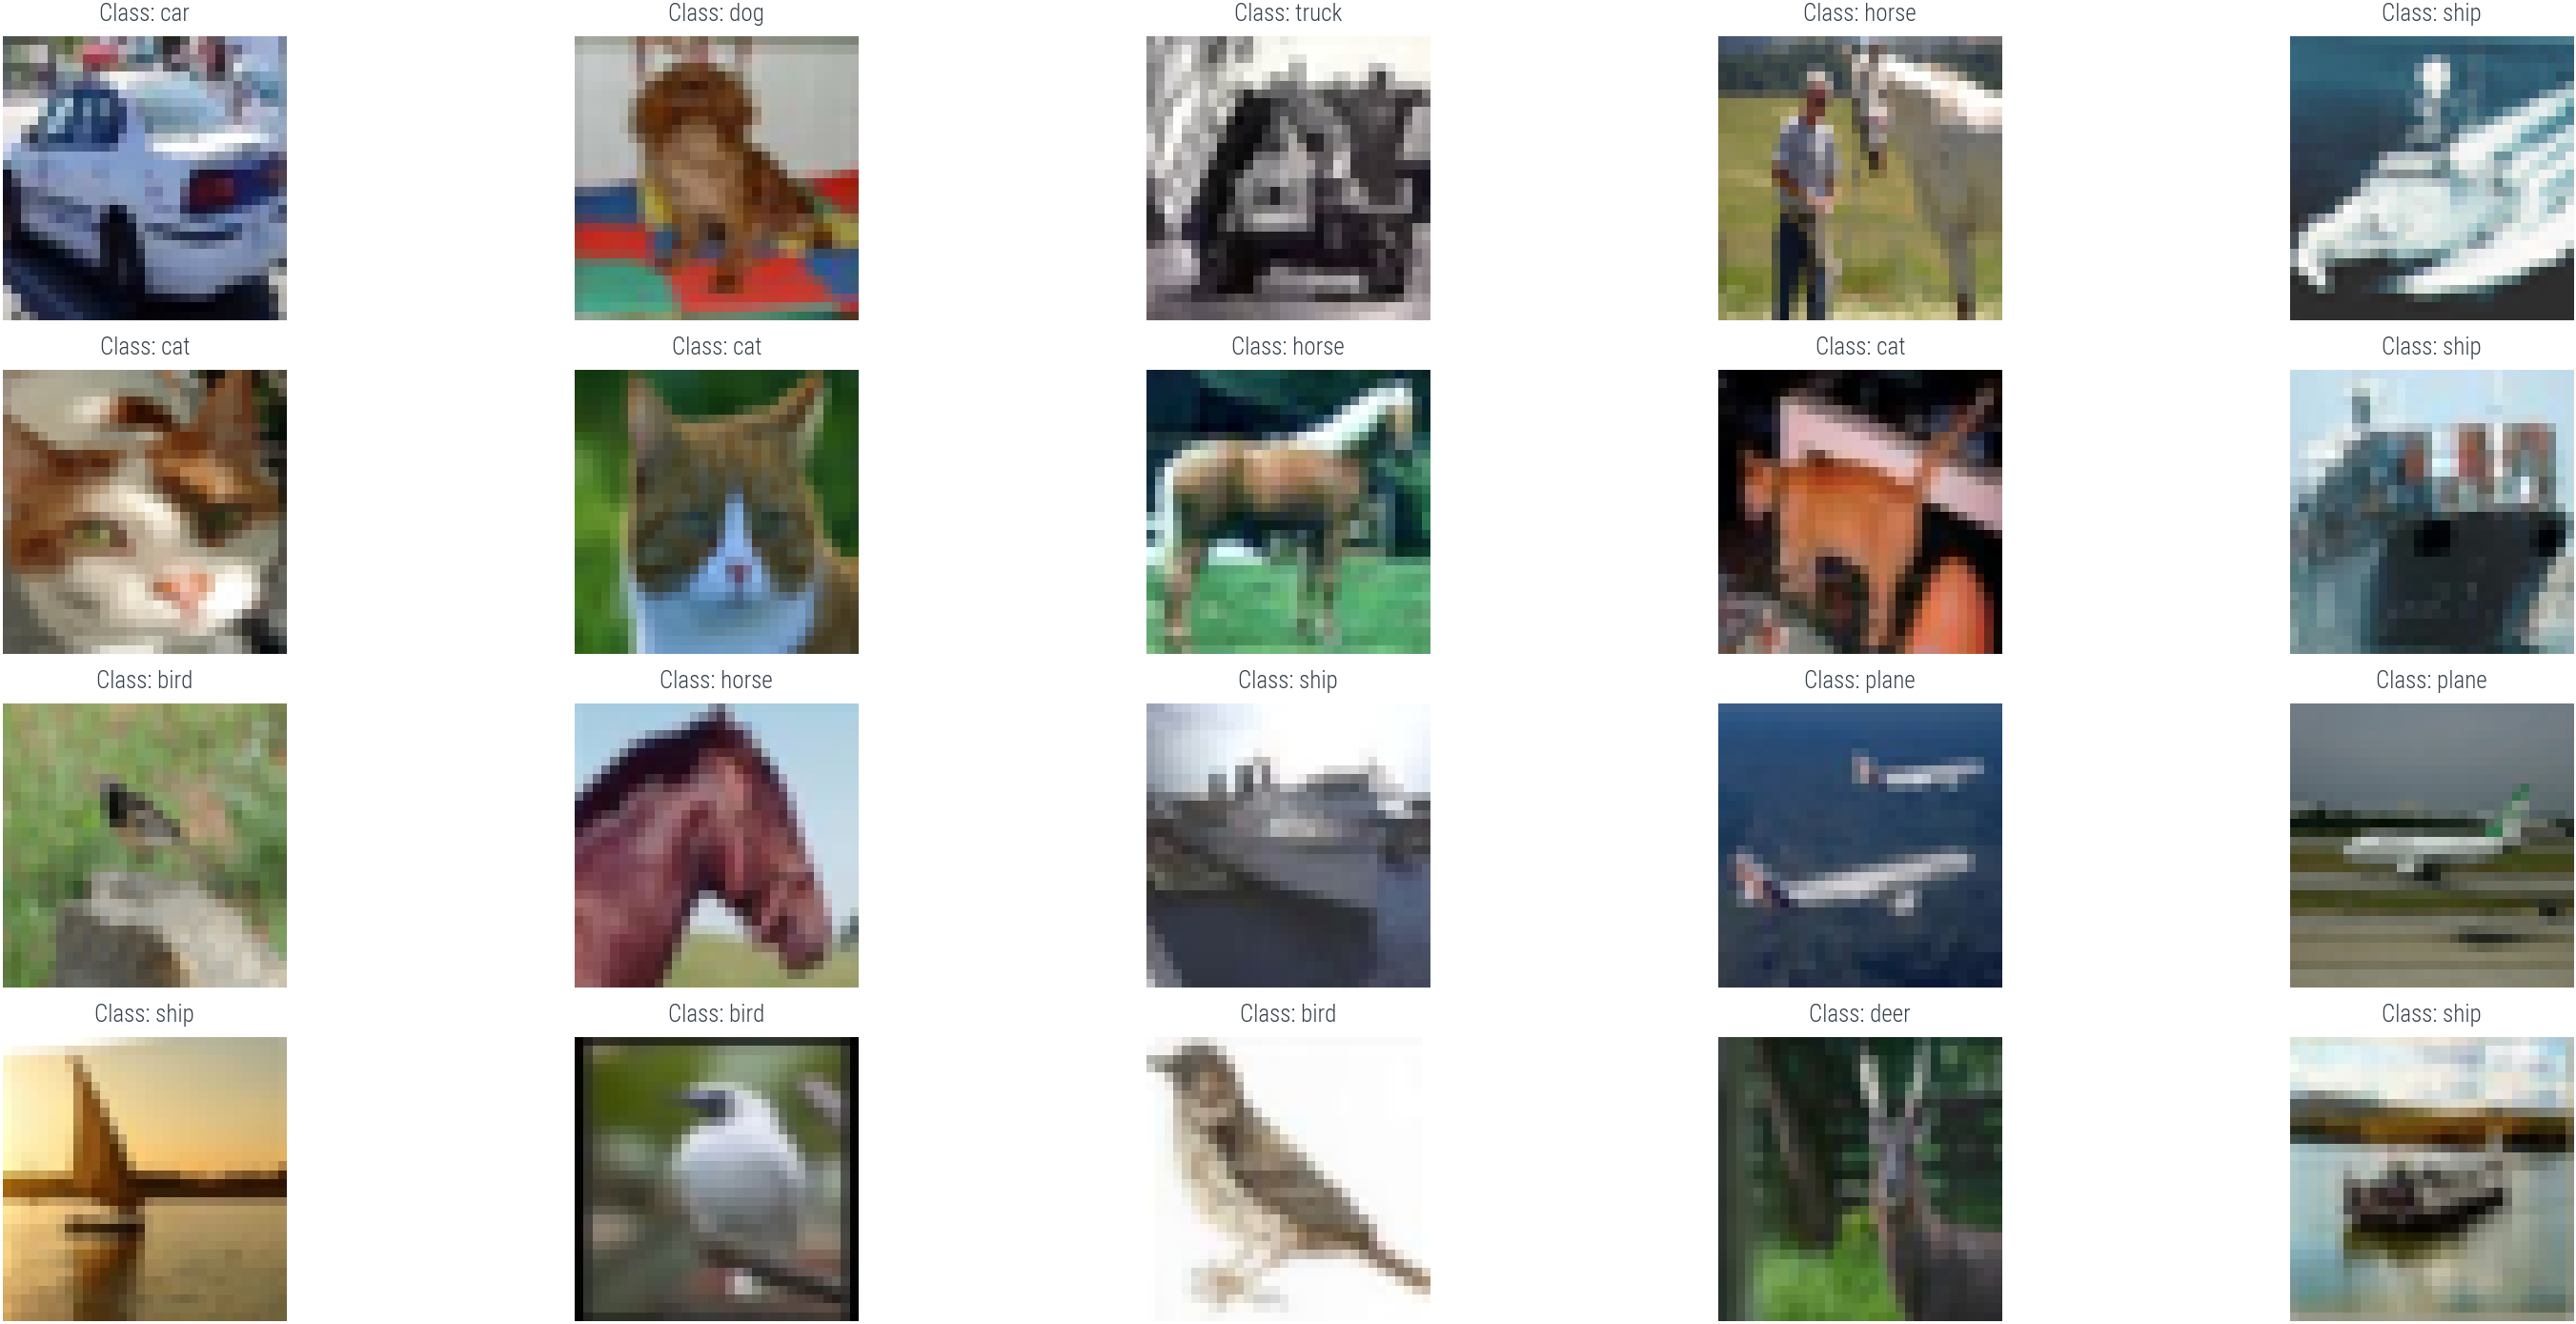

In [53]:
# Define a function to display transformed images from a dataloader with class names
def show_transformed_images_with_class_names(dataloader, classes, num_images=20):
    # Get a batch of data from the dataloader
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    # Plot the transformed images with class names
    plt.figure(figsize=(15, 7))
    for i in range(num_images):
        plt.subplot(4, 5, i + 1)
        image = images[i]  # No need to convert it to PIL, it's already a tensor
        image = image / 2 + 0.5  # Unnormalize the image
        image = transforms.ToPILImage()(image)  # Convert tensor to PIL image
        plt.imshow(image)
        class_name = classes[labels[i].item()]
        plt.title(f"Class: {class_name}")
        plt.axis('off')

    plt.show()

# Plot 20 transformed images from the train_loader with class names
show_transformed_images_with_class_names(train_loader, classes, num_images=20)

In [54]:
# Simple CNN model 
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch.nn as nn
import torch.nn.functional as F

class Featurizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2) # 2x2 max pooling
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 kernel

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # conv1 -> relu -> pool
        x = self.pool(F.relu(self.conv2(x))) # conv2 -> relu -> pool
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        return x

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16 * 5 * 5 input features, 120 output features
        self.fc2 = nn.Linear(120, 84) # 120 input features, 84 output features
        self.fc3 = nn.Linear(84, 10) # 84 input features, 10 output features

    def forward(self, x):
        x = F.relu(self.fc1(x)) # fc1 -> relu
        x = F.relu(self.fc2(x)) # fc2 -> relu
        x = self.fc3(x) # fc3
        return x

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.featurizer = Featurizer()
        self.classifier = Classifier()

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

# Train loader to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net().to(device)

In [55]:
net

Net(
  (featurizer): Featurizer(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [56]:
# Number of parameters in the model
sum(p.numel() for p in net.parameters())

62006

In [57]:
net(torch.randn(1, 3, 32, 32).to(device)).shape

torch.Size([1, 10])

In [58]:
net.featurizer(torch.randn(1, 3, 32, 32).to(device)).shape

torch.Size([1, 400])

In [59]:
# Run the featurizer on a batch of images from the train_loader
net.featurizer(next(iter(train_loader))[0].to(device)).shape

torch.Size([32, 400])

In [60]:
def get_features(net, dataloader):
    # Get features of all train images
    feature_set = []
    labels_set = []
    with torch.no_grad():
        for images, labels in tqdm(train_loader):
            features = net.featurizer(images.to(device)).cpu().numpy()
            feature_set.append(features)
            labels_set.append(labels.cpu().numpy())
        fs = np.concatenate(feature_set)
        ls = np.concatenate(labels_set)
    return fs, ls

In [61]:
fs, ls = get_features(net, train_loader)
pd.DataFrame(fs).describe()

100%|██████████| 16/16 [00:00<00:00, 71.61it/s]


,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.091329,0.087885,0.086788,0.084873,0.090187,0.092795,0.087911,0.088021,0.091649,0.094145,...,0.191483,0.194764,0.191770,0.194463,0.193864,0.188093,0.196605,0.201080,0.195942,0.192922
std,0.091218,0.088125,0.088335,0.088852,0.092749,0.086735,0.084338,0.080511,0.082279,0.088177,...,0.059063,0.061280,0.056797,0.057884,0.059597,0.060601,0.058060,0.057993,0.057885,0.062459
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.047218,0.062562,0.066740,0.042768,0.042826,0.055258,0.063112,0.069746,0.065201,0.051800
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.007218,0.009231,0.014772,0.011328,0.000000,...,0.146653,0.152389,0.153018,0.154077,0.151799,0.147186,0.153952,0.159849,0.153638,0.145836
50%,0.072107,0.069979,0.063602,0.058341,0.068637,0.078781,0.069379,0.073018,0.078809,0.074915,...,0.189776,0.188121,0.186905,0.192819,0.192365,0.185419,0.192277,0.199140,0.195395,0.191695
75%,0.149946,0.149128,0.151544,0.144891,0.157249,0.153492,0.139434,0.146813,0.152826,0.156623,...,0.231643,0.230178,0.225017,0.231723,0.234193,0.224264,0.234395,0.235855,0.233727,0.230274
max,0.347605,0.348281,0.383828,0.359835,0.374650,0.356161,0.449995,0.347241,0.405360,0.388658,...,0.384562,0.448428,0.362724,0.416099,0.382273,0.378269,0.367659,0.382106,0.374891,0.380713


100%|██████████| 16/16 [00:00<00:00, 72.62it/s]


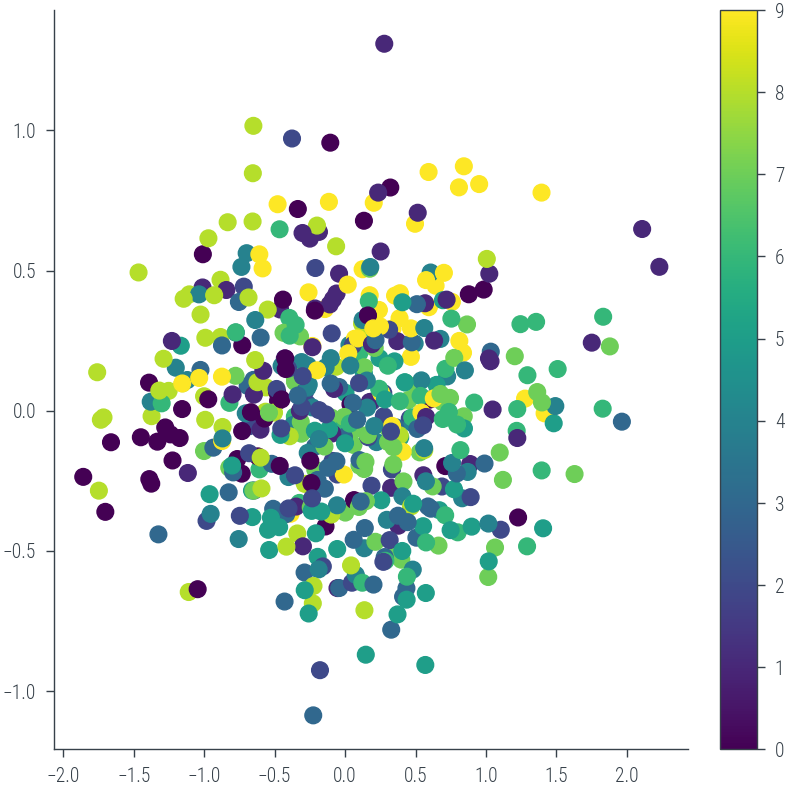

In [62]:
def plot_PCA_embedding(net, dataloader):
    fs, ls = get_features(net, dataloader)
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(fs)

    plt.figure(figsize=(4, 4))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=ls)
    plt.colorbar()
    
plot_PCA_embedding(net, train_loader)

In [63]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [64]:
losses = []
for epoch in range(100):
    # Load a batch of data from the train_loader
    for i, data in enumerate(train_loader):
        # Get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Print statistics
    losses.append(loss.item())
    if epoch % 20 == 0:
        print(f'Epoch {epoch + 1}, loss {loss.item():.3f}')

Epoch 1, loss 2.278
Epoch 21, loss 0.991
Epoch 41, loss 0.042
Epoch 61, loss 0.008
Epoch 81, loss 0.003


Text(0, 0.5, 'Loss')

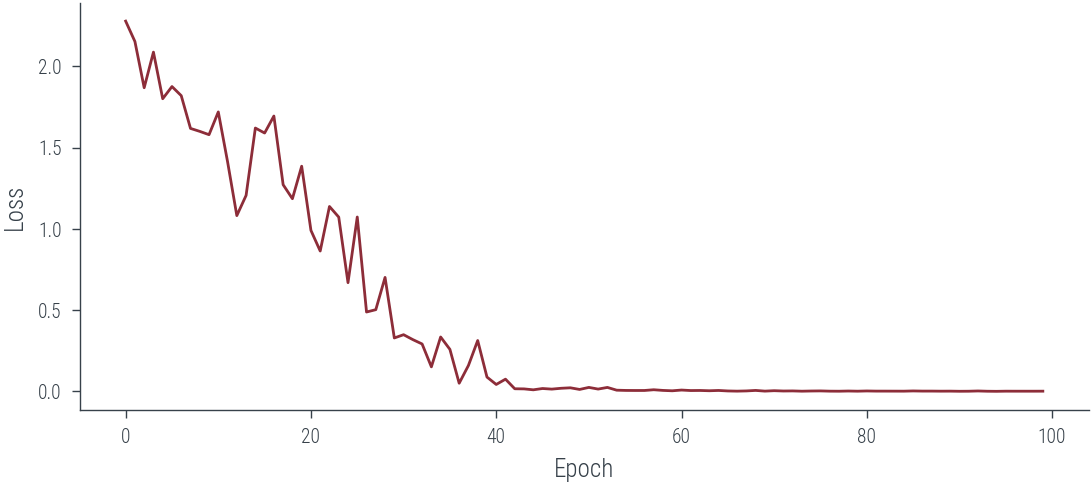

In [65]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

100%|██████████| 16/16 [00:00<00:00, 74.84it/s]


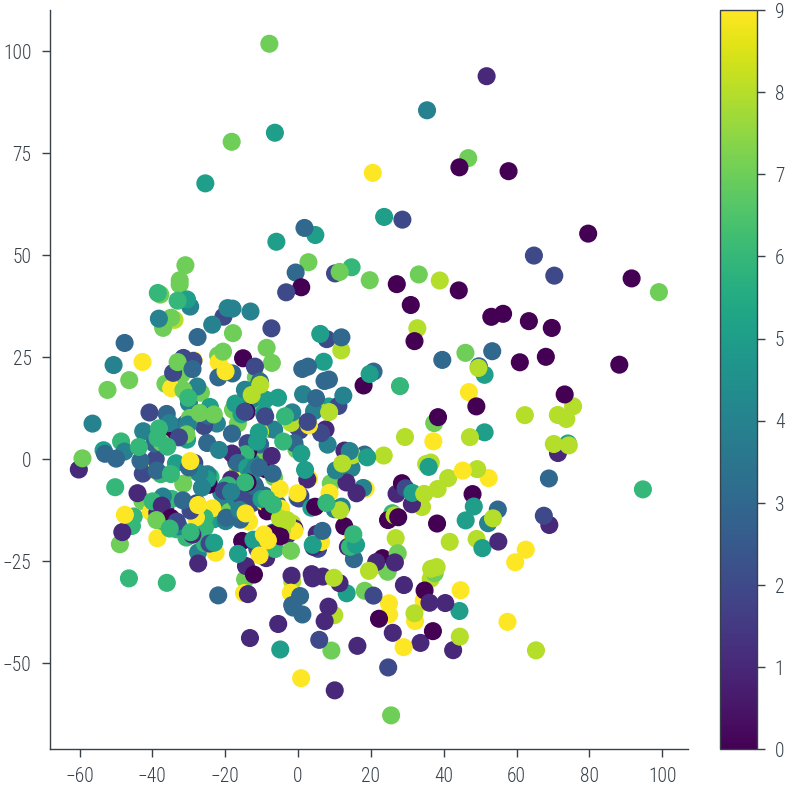

In [66]:
plot_PCA_embedding(net, train_loader)

In [67]:
# Obtain the confusion matrix for the test set
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(net, dataloader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return confusion_matrix(y_true, y_pred)

cm = get_confusion_matrix(net, test_loader)

100%|██████████| 32/32 [00:00<00:00, 173.87it/s]


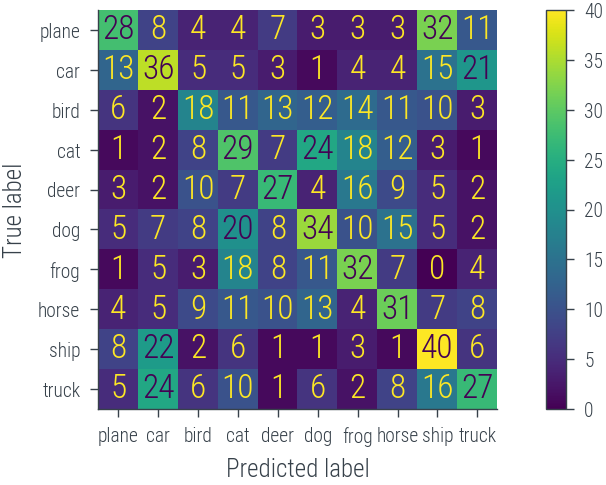

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(cm, display_labels=classes).plot()

In [69]:
from sklearn.metrics import accuracy_score, f1_score

def get_accuracy_and_f1_scores(net, dataloader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

accuracy_score_test, f1_score_test = get_accuracy_and_f1_scores(net, test_loader)
print(f'Test Accuracy: {accuracy_score_test:.3f}')
print(f'Test F1 score: {f1_score_test:.3f}')

accuracy_score_train, f1_score_train = get_accuracy_and_f1_scores(net, train_loader)
print(f'Train Accuracy: {accuracy_score_train:.3f}')
print(f'Train F1 score: {f1_score_train:.3f}')


100%|██████████| 32/32 [00:00<00:00, 168.63it/s]


Test Accuracy: 0.302
Test F1 score: 0.301


100%|██████████| 16/16 [00:00<00:00, 70.01it/s]

Train Accuracy: 1.000
Train F1 score: 1.000


In [63]:
### CoreSet based Active Learning
### Extract features from the last layer of the CNN

net.eval()
with torch.no_grad():
    features = net(torch.stack([ds_cifar[idx][0] for idx in range(len(ds_cifar))])).numpy()

features.shape

(50000, 10)